In [1]:
import qutip as qt
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt
from scqubits.core.circuit_input import convert_value_to_GHz

# Simulating FTF circuit using `scqubits`

<div style="text-align:center;">
  <img
    src="./scq_demo_FTF.jpeg"
    alt="Circuit"
    style="width:300px; height:auto;"
  >
</div>

## Step 1: Build the FTF circuit

#### Parameters

In [2]:
# Qubit A (mode 1)
C_1 = 13 # fF
L_1 = 0.3 # uH
E_J1 = 4.4 # GHz

# Qubit B (mode 3)
C_3 = 12 # fF
L_3 = 0.3 # uH
E_J3 = 4.1 # GHz

# Coupler (mode 2)
C_2 = 60 # fF
E_J2 = 8 # GHz

# Coupling capacitance
C_c = 3 # fF

# convert capacitance and inductance to energy unit (GHz)
E_Cc = convert_value_to_GHz(C_c, "fF") 
E_C1 = convert_value_to_GHz(C_1, "fF") 
E_C2 = convert_value_to_GHz(C_2, "fF") 
E_C3 = convert_value_to_GHz(C_3, "fF") 
E_L1 = convert_value_to_GHz(L_1, "uH") 
E_L3 = convert_value_to_GHz(L_3, "uH") 

# pulse parameters: 
amp = 0.02  # GHz

# simulation dimensions
# native basis truncation
cutoff_q = 110  # fluxonium
cutoff_c = 30  # transmon coupler 
# bare eigenstate truncation
dim_q = 5  # fluxonium  
dim_c = 5  # transmon coupler 
# full eigenstates truncation for time-dynamical simulation
dim_dyn = 50 

#### Create the joint quantum system

In [3]:
# define the circuit by specifying elements on each branch
gnd_yaml = f"""
# fluxonium 1
- ["JJ", 0, 1, E_J1 = {E_J1}, E_C1 = {E_C1}]
- ["L", 0, 1, E_L1 = {E_L1}]

# coupling
- ["C", 1, 2, E_Cc = {E_Cc}]

# transmon coupler
- ["JJ", 0, 2, E_J2 = {E_J2}, E_C2 = {E_C2}]

# coupling
- ["C", 2, 3, E_Cc]

# fluxonium
- ["JJ", 0, 3, E_J3 = {E_J3}, E_C3 = {E_C3}]
- ["L", 0, 3, E_L3 = {E_L3}]
"""

circ_gnd = scq.Circuit(
    gnd_yaml,
    from_file = False,
)

# scqubits.Circuit automatically identifies two external flux dependences
# we set both qubit to be biased by half a flux quantum
circ_gnd.Φ1 = 0.5
circ_gnd.Φ2 = 0.5

# configure the Circuit object
circ_gnd.configure(
    # perform no variable transformation
    transformation_matrix=np.eye(3),
    # specify hierarchical diagonalization: treat each node as a subsystem
    system_hierarchy=[[1], [2], [3]],
    # truncation of for each subsystem
    subsystem_trunc_dims=[dim_q, dim_c, dim_q],
)

# for each node variable, we define its cutoff for native basis
circ_gnd.cutoff_ext_1 = cutoff_q
circ_gnd.cutoff_n_2 = cutoff_c
circ_gnd.cutoff_ext_3 = cutoff_q

# print the Hamiltonian
circ_gnd.sym_hamiltonian()

<IPython.core.display.Latex object>

In [4]:
# print the eigenenergies of each subsystem
for subsys in circ_gnd.subsystems:
    evals = subsys.eigenvals()
    print(evals - evals[0])

[0.         0.31799844 4.41933501 6.40590373 9.85744416]
[ 0.          4.04903836  7.71721159 11.05578147 13.11164356]
[ 0.          0.42180964  4.41733633  6.65585998 10.06628452]


## Parameter sweep
**Goal:** sweep over the resonator frequency, study the static and dynamic properties of the circuit, and finally find a good resonator frequency for design.

In [5]:
# extract the HilbertSpace object for ParameterSweep
hspace = circ_gnd.hilbert_space

# parameters to be swept over
swept_para = {      
    'E_J2': np.linspace(6, 12, 31),
}

# instruct the ParameterSweep object on how to update the system when sweeping
def update_hspace(E_J2):
    circ_gnd.E_J2 = E_J2
    
# initialize the ParameterSweep
sweep = scq.ParameterSweep(
    hilbertspace = hspace,
    paramvals_by_name = swept_para,
    update_hilbertspace = update_hspace,
    evals_count = hspace.dimension,
    # utilize branch analysis to label the eigenstates
    labeling_scheme = "LX",
)

Bare spectra:   0%|          | 0/31 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/31 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/31 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/31 [00:00<?, ?it/s]

## Static properties

#### For plotting...
For nearly all of the plots below, use omega as the x-axis.

In [6]:
x_label_1d = "E_J2"
x_val_1d = swept_para[x_label_1d]

#### ZZ
The most general form of the diagonalized two-qubits Hamiltonian:
$$
H^\mathrm{eff} = -\frac{1}{2} \omega_A \sigma_A^z - \frac{1}{2} \omega_B \sigma_B^z - \frac{\xi}{4} \sigma_A^z \sigma_B^z
$$
In `scqubits`, the ZZ interaction strength $\xi$ is already computed and stored in `sweep["kerr"]`

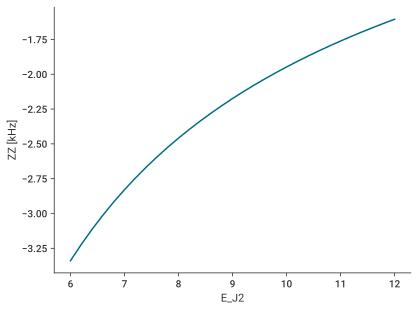

In [7]:
(sweep["kerr"][0, 2][..., 1, 1] * 1e6).plot()
plt.xlabel(x_label_1d)
plt.ylabel("ZZ [kHz]")
plt.show()

#### The spectrum of the circuit

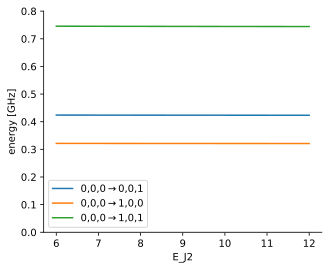

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)

ax = ax
sweep.plot_transitions(
    initial = (0, 0, 0),
    final = [
        (0, 0, 1),
        (1, 0, 0),
        (1, 0, 1),
    ],
    fig_ax = (fig, ax),
)
ax.set_ylim(0, 0.8)
ax.legend()

plt.show()

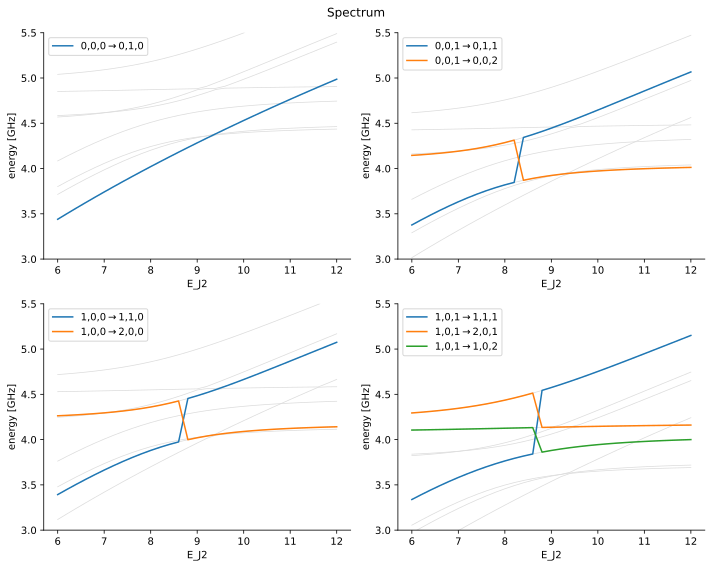

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=300)

ax = axs[0, 0]
sweep.plot_transitions(
    initial = (0, 0, 0),
    final = [
        (0, 1, 0),
    ],
    fig_ax = (fig, ax),
)
ax.set_ylim(3, 5.5)
ax.legend()

ax = axs[0, 1]
sweep.plot_transitions(
    initial = (0, 0, 1),
    final = [
        (0, 1, 1),
        (0, 0, 2),
    ],
    fig_ax = (fig, ax),
)
ax.set_ylim(3, 5.5)
ax.legend()

ax = axs[1, 0]
sweep.plot_transitions(
    initial = (1, 0, 0),
    final = [
        (1, 1, 0),
        (2, 0, 0),
    ],
    fig_ax = (fig, ax),
)
ax.set_ylim(3, 5.5)
ax.legend()

ax = axs[1, 1]
sweep.plot_transitions(
    initial = (1, 0, 1),
    final = [
        (1, 1, 1),
        (2, 0, 1),
        (1, 0, 2),
    ],
    fig_ax = (fig, ax),
)
ax.set_ylim(3, 5.5)
ax.legend()

fig.suptitle("Spectrum")
plt.tight_layout()
plt.show()


## Ingredients for gates

In [10]:
# define the computational basis with bare labels
computational_bare = [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1)]

# identify the dressed index of these computational states
computational_dressed_arrs = np.array([
    sweep.dressed_index(bare)
    for bare in computational_bare
])

# we are sweeping over the resonator frequency, which is at a relatively high energy,
# the labeling of the low energy states should not change during the sweep
print(computational_dressed_arrs)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [11]:
# define the transition to be driven with bare labels:
initial_bare = (1, 0, 1)
final_bare = (1, 1, 1)  # add a photon to the resonator mode

# compute the drive frequency
drive_freq_arr = (
    sweep.energy_by_bare_index(final_bare)
    - sweep.energy_by_bare_index(initial_bare)
)   # in GHz
drive_period_arr = 1 / drive_freq_arr   # in ns

print(drive_freq_arr)
print(drive_period_arr)

[3.33835371 3.39136946 3.44234389 3.4911853  3.53779003 3.58204609
 3.62383885 3.66305889 3.69961165 3.73342822 3.76447562 3.79276479
 3.81835452 3.84135032 4.54378588 4.57536108 4.60848396 4.64297654
 4.67865985 4.71536148 4.75292059 4.79119088 4.83004174 4.86935829
 4.90904054 4.94900218 4.98916917 5.02947828 5.06987568 5.11031564
 5.15075942]
[0.29954885 0.29486613 0.29049974 0.28643567 0.28266234 0.27917005
 0.27595046 0.27299588 0.27029864 0.26785034 0.26564125 0.2636599
 0.26189292 0.26032512 0.22008079 0.21856199 0.2169911  0.21537908
 0.21373642 0.21207282 0.21039695 0.20871638 0.20703755 0.20536587
 0.20370579 0.20206093 0.20043417 0.19882778 0.1972435  0.19568263
 0.19414613]


In [12]:
# for each resonator frequency, compute the drive operator: resonator charge operator

# utility functions to transform an operator to a new basis
def trans_by_kets(
    kets
):
    """
    Given a list of kets = [|k1>, |k2>, ...], 
    calculate a unitary operator that can perform basis transformation 
    from the current basis to the basis of kets.
    """
    dim = kets[0].dims[0]
    new_dim = [dim, [len(kets)]] 
    
    # turn them into ndarray for stacking purposes
    kets = [ket.full().ravel() for ket in kets]
    
    # stack all column vectors 
    trans = np.stack(kets, axis=-1)
    
    return qt.Qobj(trans, dims=new_dim)

def oprt_in_basis(
    oprt,
    ket_basis,
):
    """
    Convert an operator to a matrix representation described by a given set of basis.
    """
    bra_trans = trans_by_kets(ket_basis)
    ket_trans = trans_by_kets(ket_basis)
    data = bra_trans.dag() * oprt * ket_trans
    return data

def sweep_drive_op(
    ps: scq.ParameterSweep,
    paramindex_tuple,
    paramvals_tuple,
    trunc: int = 30,
):
    # update the system before extracting the operator
    update_hspace(*paramvals_tuple)
    
    # extract the operator
    res_n_op_sparse = circ_gnd.n2_operator()
    
    # convert to a Qobj in qutip with the correct dimensions
    dims = hspace.subsystem_dims
    res_n_op = qt.Qobj(res_n_op_sparse, dims = [dims, dims])
        
    # convert to eigenbasis for time-dynamical simulation
    drive_op = oprt_in_basis(
        res_n_op,
        ps["evecs"][paramindex_tuple][:trunc]
    ) * np.pi * 2
    
    return drive_op

# define a custom sweep that call sweep_drive_op for each resonator frequency
sweep.add_sweep(
    sweep_drive_op,
    "drive_op",
    trunc = dim_dyn,
)

sweeping sweep_drive_op:   0%|          | 0/31 [00:00<?, ?it/s]

## 2Q gate simulation

In [13]:
def sweep_time_dynamics(
    ps: scq.ParameterSweep, 
    paramindex_tuple,
    paramvals_tuple,
    t_list,
    trunc: int = 30,
):
    # grab all ingredients for the Hamiltonian -------------------------
    ham = qt.qdiags(ps["evals"][paramindex_tuple][:trunc], 0) * np.pi * 2
    drive_freq = drive_freq_arr[paramindex_tuple] * np.pi * 2
    drive_op = qt.Qobj(ps["drive_op"][paramindex_tuple][:trunc, :trunc])

    ham_t = [
        ham,
        [
            amp * drive_op, 
            f"cos({drive_freq}*t)"
        ],
    ]

    # time-dynamical simulation with qutip -----------------------------
    props = qt.propagator(
        ham_t, 
        t_list,
        options = {
            "nsteps": 1000000,
            "atol": 1e-10,
            "rtol": 1e-10,
        }
    )

    # extract the matrix elements of the props -------------------------
    # computational states' dressed label
    comp_dressed_label = computational_dressed_arrs[:, *paramindex_tuple]
    
    # save the diagonal propagator matrix element
    data = np.zeros((len(t_list), 4))
    for state_idx, dressed_label in enumerate(comp_dressed_label):
        for t_idx, propagator in enumerate(props):
            data[t_idx, state_idx] = np.abs(
                propagator.full()[dressed_label, dressed_label]
            )**2

    # for each parameter value, we save an array of data with shape (len(t_list), 4)
    # after iterating over all parameter values, we have a 3D array of shape 
    # (n_param, len(t_list), 4)
    return data

t_list = np.linspace(0, 100, 101)
sweep.add_sweep(
    sweep_time_dynamics,
    "pop_t",
    t_list = t_list,
    trunc = dim_dyn,
)

sweeping sweep_time_dynamics:   0%|          | 0/31 [00:00<?, ?it/s]

 C:\Users\drjen\miniconda3\envs\ucla\Lib\site-packages\qutip\core\coefficient.py: 420

KeyboardInterrupt: 

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
x_mesh, t_mesh = np.meshgrid(x_val_1d, t_list, indexing="ij")

axs = axs.flatten()
for idx, ax in enumerate(axs):
    # sweep["pop_t"] has shape (n_param, len(t_list), 4)
    # we extract the data for a specific state index 
    z_mesh = sweep["pop_t"][:,:,idx]
    
    im = ax.pcolormesh(
        x_mesh, 
        t_mesh, 
        z_mesh,    
        vmin=0, vmax=1
    )
    plt.colorbar(im, ax=ax)
    ax.set_xlabel(x_label_1d)
    ax.set_ylabel("time [ns]")
    bare_label_str = " ".join([str(bare) for bare in computational_bare[idx]])
    ax.set_title(fr"$|\langle{bare_label_str}| U(t) |{bare_label_str}\rangle|^2$")
    
plt.tight_layout()
plt.show()